# Praca domowa 4
Tematem pracy domowej było zaimplementowanie modelu SVM dla dwóch róznych zbiorów danych i sprawdzić teze czy skalowanie danych wpływa na wyniki modelu.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

## Zbiór apartments
### Krótka analiza zbioru 
Po krótkiej analizie widzimy, że w zbiorze nie ma braków w danych. widzimy również, że mamy do czyninia z jedną kolumną kategoryczną. Będziemy musieli ją przeskalować.

In [4]:
from dalex.datasets import load_apartments
apart = load_apartments()
apart.head(3)

,m2_price,construction_year,surface,floor,no_rooms,district
1,5897,1953,25,3,1,Srodmiescie
2,1818,1992,143,9,5,Bielany
3,3643,1937,56,1,2,Praga


In [5]:
apart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2_price           1000 non-null   int64 
 1   construction_year  1000 non-null   int64 
 2   surface            1000 non-null   int64 
 3   floor              1000 non-null   int64 
 4   no_rooms           1000 non-null   int64 
 5   district           1000 non-null   object
dtypes: int64(5), object(1)
memory usage: 54.7+ KB


In [6]:
apart.describe()

,m2_price,construction_year,surface,floor,no_rooms
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3487.019000,1964.823000,85.590000,5.623000,3.360000
std,906.691651,25.831511,37.874799,2.899876,1.381415
min,1607.000000,1920.000000,20.000000,1.000000,1.000000
25%,2857.000000,1943.000000,53.000000,3.000000,2.000000
50%,3386.000000,1965.000000,85.500000,6.000000,3.000000
75%,4018.250000,1988.000000,118.000000,8.000000,4.000000
max,6595.000000,2010.000000,150.000000,10.000000,6.000000


Widzimy jak wyglądają rozkłady poszczególnych zmiennych. Rozkład ceny i liczby pokoi przypomina rozkład normalny z ogonem z prawej strony, reszta natomiast wygląda całkiem jednostajnie.

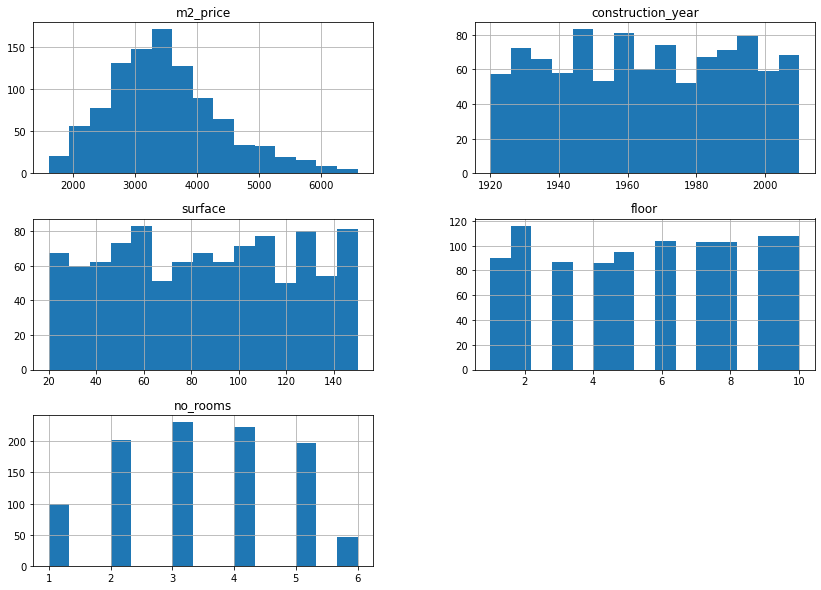

In [7]:
apart.hist(figsize=(14,10), bins=15)
plt.show()

### SVM dla amartments 
Na początku dzielimy zbiór na zbiór testowy i treningowy. Następnie jako, że zbiór zawiera kolumne kategoryczną zawierającą informacje o dzielnicy w której mieści się apartament, kodyjemy tą zmienną. Jako że jest tylko 10 kategorii kożystamy z OneHot encodera.

In [8]:
# Dzielenie zbioru na treningowy i testowy 
x_apart_train, x_apart_test, y_apart_train, y_apart_test = train_test_split(
    apart.drop(columns=['m2_price']), apart['m2_price'], test_size=0.3, random_state=13)

In [9]:
# OneHot
x_apart_train = pd.get_dummies(data = x_apart_train, columns = ['district'])
x_apart_test = pd.get_dummies(data = x_apart_test, columns = ['district'])
x_apart_train.shape
print(" Rozmiar zbioru treningowego:", x_apart_train.shape)

 Rozmiar zbioru treningowego: (700, 14)


Następnie treniujemy dwa modele SVR. Najpierw trenujemy model bez standaryzacji danych. Następnie trenujemy idnetyczny model, ale wpierw przeskalowujemy wartości danych.

In [10]:
# Model bez skalowania
apart_model_unscaled = SVR()
apart_model_unscaled.fit(x_apart_train, y_apart_train)

# Model ze skalowaniem 
preprocessing = StandardScaler()
apart_model_scaled = make_pipeline(preprocessing, SVR())
apart_model_scaled.fit(x_apart_train, y_apart_train)

compare = pd.DataFrame(columns=["#", "Bez skalowania", "Ze skalowaniem"])
compare["#"]= ["MSE na zbiorze treningowym", "MSE na zbiorze testowym"]
compare["Bez skalowania"]= [mean_squared_error(y_apart_train, apart_model_unscaled.predict(x_apart_train), squared=False),
                            mean_squared_error(y_apart_test, apart_model_unscaled.predict(x_apart_test), squared=False)]
compare["Ze skalowaniem"]= [mean_squared_error(y_apart_train, apart_model_scaled.predict(x_apart_train), squared=False),
                            mean_squared_error(y_apart_test, apart_model_scaled.predict(x_apart_test), squared=False)]

print(compare.to_string(index=False))

                          #  Bez skalowania  Ze skalowaniem
 MSE na zbiorze treningowym      916.644110      895.910705
    MSE na zbiorze testowym      905.405174      884.420810


W ramce wyżej widzimy, że błąd maleje, gdy mamy do czynienia z przeskalowanymi danymi. Każda minimalizacja błędów jest dla nas cenna, więc warto jest stosować standaryzację przed użyciem SVM. Potwierdza to teze z linkowanego artykułu.

## Zbiór diabetes
### Krótka analiza zbioru

Jako drugi zbiór wybrałem zbiór diabetes. Podobnie jak wcześniej przyglądamy się powierzchownie naszym danym. Również nie mają one braków w danych. Nie maja również zmiennych kategorycznych. Dane te są też już przeskalowane. 

In [11]:
from sklearn.datasets import load_diabetes
diab_raw = load_diabetes(as_frame=True)
diab = diab_raw['data']
diab_target = diab_raw['target']
diab.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


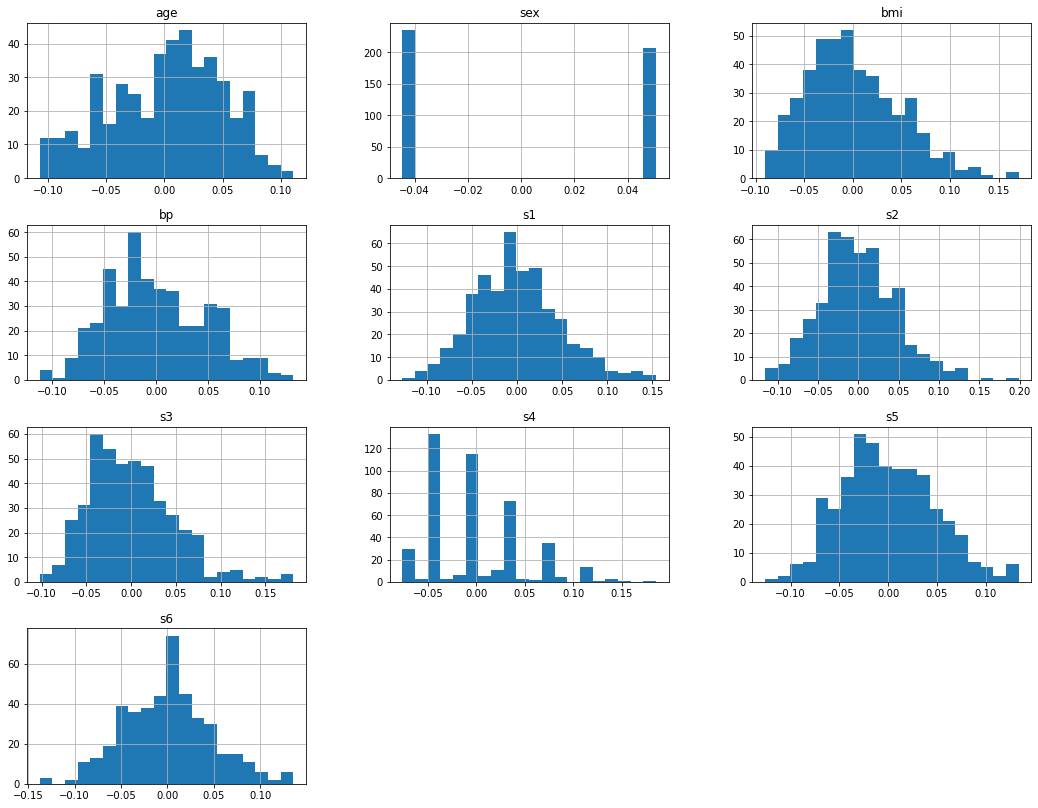

In [12]:
diab.hist(figsize=(18,14), bins=20)
plt.show()

### SVM dla diabetes
W tym przypadku nie mamy do czynienia z cechami kategorycznymi. Jak wspomniałem dane są już przeskalowane. Pozostaje nam zatem jedynie podział na zbiór treningowy i testowy.

In [111]:
# Podział na zbiory testowy i treningowy
x_diab_train, x_diab_test, y_diab_train, y_diab_test = train_test_split(
    diab, diab_target, test_size=0.3, random_state=13)

In [112]:
# Tworzenie modelu dla diabetes
diab_model_scaled = SVR()
diab_model_scaled.fit(x_diab_train, y_diab_train)

print('MSE na zbiorze treningowym: ', mean_squared_error(y_diab_train, diab_model_scaled.predict(x_diab_train), squared=False))
print('MSE na zbiorze testowym: ', mean_squared_error(y_diab_test, diab_model_scaled.predict(x_diab_test), squared=False))

MSE na zbiorze treningowym:  72.53560139173298
MSE na zbiorze testowym:  67.28805281953838


## Strojenie parametrów 
Za pomocą Random Search będziemy teraz stroić parametry modeli.

### Strojenie modelu dla apartments

In [120]:
params = {'svr__C': np.arange(0.1, 500, 0.5),
            'svr__gamma': ['scale', 'auto', 1],
            'svr__degree': np.arange(1,  10, 1),
            'svr__kernel':['rbf']}

random = RandomizedSearchCV(estimator=make_pipeline(preprocessing, SVR()), param_distributions=params, n_iter= 200, n_jobs=-1)

random_result = random.fit(x_apart_train, y_apart_train)

best_estimator = random.best_estimator_
print(random_result.best_params_)
print('MSE train for best estimator: ', mean_squared_error(y_apart_train, best_estimator.predict(x_apart_train), squared=False))
print('MSE test for best estimator: ', mean_squared_error(y_apart_test, best_estimator.predict(x_apart_test), squared=False))

{'svr__kernel': 'rbf', 'svr__gamma': 'scale', 'svr__degree': 3, 'svr__C': 496.1}
MSE train for best estimator:  164.74915202096034
MSE test for best estimator:  195.04014864427648


### Strojenie modelu dla diabetes

In [121]:
svr_diabetes = make_pipeline(SVR())
random_diabetes = RandomizedSearchCV(estimator=svr_diabetes, param_distributions=params, n_iter= 100, n_jobs=-1)

random_result_diabetes = random_diabetes.fit(x_diab_train, y_diab_train)

best_estimator_diabetes = random_diabetes.best_estimator_
print(random_result_diabetes.best_params_)
print('MSE train for best estimator: ', mean_squared_error(y_diab_train, best_estimator_diabetes.predict(x_diab_train), squared=False))
print('MSE test for best estimator: ', mean_squared_error(y_diab_test, best_estimator_diabetes.predict(x_diab_test), squared=False))

{'svr__kernel': 'rbf', 'svr__gamma': 1, 'svr__degree': 7, 'svr__C': 492.1}
MSE train for best estimator:  53.172759814711455
MSE test for best estimator:  54.232166073502775


## Wnioski 
W obu przypadkach strojenie parametrów znacznie zmniejszyło błąd. Poprawa w przypadku strojenia parametrów okazała się byc dużo bardziej znacząca niż skalowanie parametrów. Wnisek jest taki, że zdecydowanie ważniejsze jest strojenie parametrów. Jeżeli zależy nam jednak na jak najlepszych wynikach pownniśmy również przskalować dane. Różnica nie jest powalająca, ale jeżeli chcemy tworzyć solidne modele to każda poprawa wyniku powninna być dla nas instotna